# Decision Tree and Random Forests

In [1]:
import keras as k
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt

/home/atharvachalke/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Decision Tree Model
### 1. Preprocess data as done for every model
### 2. Convert assetCode to integer labels
### 3. Use Decision tree , Random Forests and Gradient Tree boosting
### 4. Generate ROC Curves to measure performance on validation set

In [2]:
#Load market data
market_train_df = pickle.load( open( "Market_train", "rb" ) )

In [3]:
#Load news data
news_train_df = pickle.load(open("News_train-002", "rb"))

In [4]:
#Preprocess( NO change to asset)
def preprocess_data(mkt_train_df, news_train_df):
    mkt_train_df['time'] = mkt_train_df['time'].dt.date
    news_train_df['time'] = news_train_df['time'].dt.date
    assetCodes = []
    index = 0
    for x in news_train_df['assetCodes']:
        x = x.split(',')[0].split("'")[1]
        assetCodes.append(x)
    news_train_df['assetCode'] = np.asarray(assetCodes)
    irrelevantColumns = ['sourceTimestamp', 'firstCreated', 'sourceId', 
                         'headline', 'provider', 'subjects', 'audiences',
                        'headlineTag', 'marketCommentary', 'assetCodes', 'assetName']
    news_train_df.drop(irrelevantColumns, axis=1, inplace=True)
    market_train_df.drop(['assetName'], axis=1, inplace=True)
    modifiednews = news_train_df.groupby(['time','assetCode'], sort=False).aggregate(np.mean).reset_index()
    
    # join news reports to market data, note many assets will have many days without news data
    merged = pd.merge(mkt_train_df, modifiednews, how='left', on=['time', 'assetCode'], copy=False) 
    merged = merged.fillna(0)
    merged.drop(['time'], axis=1,inplace= True)
     
    return merged

In [5]:
#Preprocess data
X = preprocess_data(market_train_df, news_train_df)

In [7]:
#Free up some memory
del market_train_df, news_train_df

NameError: name 'market_train_df' is not defined

In [8]:
#Get labels and drop that label from X
Y = X['returnsOpenNextMktres10']
X.drop(['returnsOpenNextMktres10'], axis=1, inplace=True)

In [9]:
#Asset code manipulation
ac = X.assetCode
ac = pd.get_dummies(ac)

In [10]:
#Convert ac to labels
ac = ac.values
ac = np.argmax(ac, axis =1)


In [11]:
#convert array to pandas dataframe
ac = pd.DataFrame(ac, columns = ['assetCode'])

In [14]:
#Get features, concat with labels and fill na values with 0s
X_new = X[['close','open','sentimentClass','sentimentNegative','sentimentNeutral','sentimentPositive']]
X_new = pd.concat((ac,X_new,Y), axis = 1)
X_new.fillna(0)
print('')

In [15]:
#make a copy of full data-set
df_stock =X_new

In [16]:
#Remove outliers
a = df_stock[df_stock.returnsOpenNextMktres10<1.5]
a = a[a.returnsOpenNextMktres10>-1.5]

In [19]:
#select features and label
X = a.iloc[:,0:-1]
Y = a.iloc[:,-1]
X.head()

,assetCode,close,open,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive
0,0,32.19,32.17,0.50,0.080418,0.568264,0.351318
1,2,11.12,11.08,0.25,0.138128,0.412758,0.449114
2,7,37.51,37.99,0.00,0.000000,0.000000,0.000000
3,8,84.74,86.23,0.00,0.000000,0.000000,0.000000
4,15,18.02,18.01,0.00,0.000000,0.000000,0.000000


In [20]:
#Convert to binary encodings
Y[Y>0] = 1
Y[Y<0] = 0

/home/atharvachalke/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/atharvachalke/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


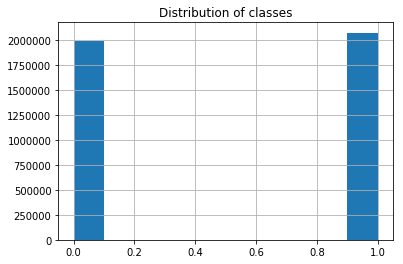

Number of class 0 is 1994317
Number of class 1 is 2078102


In [24]:
#Plot Y
plt.figure()
plt.title("Distribution of classes")
plt.grid()
plt.hist(Y)
plt.show()
print("Number of class 0 is", (Y==0).sum())
print("Number of class 1 is", (Y==1).sum())

# Decision Tree for classification

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc

In [70]:
#Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

In [71]:
#Decision tree classifier
clf_tree = DecisionTreeClassifier(max_depth=20, max_features=7)

In [72]:
#Fit data
clf_tree.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
            max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [73]:
#Get predictions, fpr, tpr for Test set
predictions = clf_tree.predict(X_test)
fpr, tpr, _ = roc_curve(Y_test,predictions)
auc_test = auc(fpr,tpr)

In [74]:
#Get predictions,fpr, tpr for train set 
predictions_train = clf_tree.predict(X_train)
fpr1,tpr1,_ = roc_curve(Y_train,predictions_train)
auc_train = auc(fpr1,tpr1)

OverflowError: Exceeded cell block limit (set 'agg.path.chunksize' rcparam)

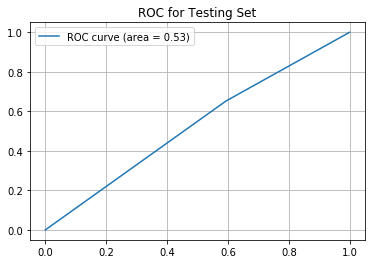

0.5292517221952958


In [77]:
#ROC AND AUC
#Plot for training set
plt.title("ROC for Training set")
plt.plot(fpr1,tpr1, label='ROC curve (area = %0.2f)' % auc_train)
plt.grid()
plt.legend()
#plt.savefig("ROC-DecisionTree-Training")
plt.show()


# Plot for test set
plt.figure()
plt.title("ROC for Testing Set")
plt.plot(fpr,tpr,label='ROC curve (area = %0.2f)' % auc_test)
plt.grid()
plt.legend()
#plt.savefig("ROC-DecisionTree-Training")
plt.show()
auc_score = auc(fpr,tpr)
print(auc_score)


# Random Forests Classifier

In [78]:
#Ensemble methods Random Forests Classifier
from sklearn.ensemble import RandomForestClassifier

/home/atharvachalke/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [92]:
#Declear Classifier
clf_RF = RandomForestClassifier(n_estimators=25, max_depth=50)

In [ ]:
#Fit training Data
clf_RF.fit(X_train,Y_train)


In [ ]:
#Get predictions,fpr, tpr for train set 
predictions_train = clf_tree.predict(X_train)
fpr1,tpr1,_ = roc_curve(Y_train,predictions_train)
auc_train = auc(fpr1,tpr1)

In [ ]:
#Get predictions, fpr,tpr for Test set
predictions = clf_tree.predict(X_test)
fpr, tpr, _ = roc_curve(Y_test,predictions)
auc_test = auc(fpr,tpr)

In [ ]:
#ROC AND AUC
#Plot for training set
plt.title("ROC for Training set")
plt.plot(fpr1,tpr1, label='ROC curve (area = %0.2f)' % auc_train)
plt.grid()
plt.legend()
plt.savefig("ROC-RandomForest-Training")
plt.show()

# Plot for test set
plt.figure()
plt.title("ROC for Training Set")
plt.plot(fpr,tpr,label='ROC curve (area = %0.2f)' % auc_test)
plt.grid()
plt.legend()
plt.savefig("ROC-RandomForest-Testing")
plt.show()
auc_score = auc(fpr,tpr)
print(auc_score)